# Agglomerative Clustering

This notebook will introduce **Agglomerative Clustering** (aka, hierarchical clustering), a powerful unsupervised method that builds a tree-like structure (a **dendrogram**) to reveal nested groupings in data.

Compared to methods like K-means and GMMs, hierarchical clustering does not assume spherical or elliptical cluster shapes and provides a full hierarchy of possible clusterings.

We will:

- construct and visualize 2D and 3D dendrograms using `scipy.cluster.hierarchy`
- apply agglomerative hierarchical clustering using `sklearn.cluster.AgglomerativeClustering`
- compare the cluster labels obtained by cutting the dendrogram to results from other clustering methods

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

# Make data

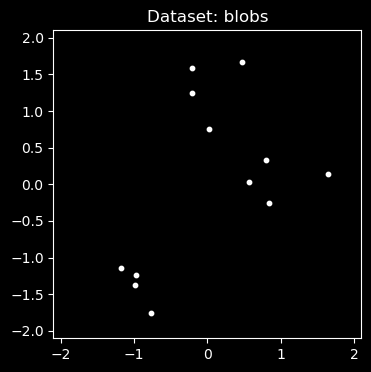

In [48]:
from sklearn.datasets import make_blobs, make_classification, make_moons, make_circles

dataset_type = 'blobs'  # try: blobs, classification, moons, circles, anisotropic, varied

if dataset_type == 'blobs':
    X1, _ = make_blobs(
        n_samples=12,
        centers=3,
        cluster_std=2,
        random_state=42
    )

elif dataset_type == 'classification':
    X1, _ = make_classification(
        n_samples=120,
        n_features=2,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=3,
        class_sep=2,
        random_state=42
    )

elif dataset_type == 'moons':
    from sklearn.datasets import make_moons
    X1, _ = make_moons(
        n_samples=120,
        noise=0.1,
        random_state=42
    )

elif dataset_type == 'circles':
    from sklearn.datasets import make_circles
    X1, _ = make_circles(
        n_samples=120,
        noise=0.05,
        factor=0.5,
        random_state=42
    )

elif dataset_type == 'anisotropic':
    X1, _ = make_blobs(
        n_samples=120,
        centers=3,
        cluster_std=1,
        random_state=42
    )
    # Apply an anisotropic linear transformation
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X1 = X1.dot(transformation)

elif dataset_type == 'varied':
    X1, _ = make_blobs(
        n_samples=120,
        centers=[[-5, -5], [0, 0], [5, 5]],
        cluster_std=[1.0, 2.5, 0.5],
        random_state=42
    )

else:
    raise ValueError("Unknown dataset_type")

# Normalize and add optional noise
n_noise = 0
X1 -= np.mean(X1, axis=0)
MAX = np.max(np.abs(X1))
X2 = np.random.uniform(-MAX, MAX, size=(n_noise, 2))

X = np.concatenate((X1, X2), axis=0)
X -= np.mean(X, axis=0)
X /= np.std(X)
MAX = np.max(np.abs(X)) * 1.2

# Plot
%matplotlib inline

plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c='w', s=10)
plt.xlim(-MAX, MAX)
plt.ylim(-MAX, MAX)
plt.gca().set_aspect('equal')
plt.title(f"Dataset: {dataset_type}")
plt.show()

# Agglomerative clustering explained

**Hierarchical clustering** builds a nested hierarchy of clusters by either:

- **Agglomerative** (bottom-up): Start with each point as its own cluster and iteratively **merge the closest pair** of clusters.
- **Divisive** (top-down): Start with all points in one cluster and recursively **split** clusters.

In this notebook, we focus on **agglomerative clustering**, which is more commonly used and implemented in both `scikit-learn` and `scipy`.

## The Process

1. Start with each data point in its own cluster.
2. Compute all pairwise distances between clusters.
3. Merge the two closest clusters.
4. Update the distance matrix to reflect the new cluster.
5. Repeat until all points are in a single cluster.

The result is a **dendrogram** — a tree structure showing the order and distance at which clusters were merged. You can choose the number of clusters by **"cutting" the dendrogram** at a desired height.

### Linkage

The way distances between clusters are computed is defined by the **linkage method**:

- **Complete linkage**:
  - Distance between clusters A and B is the **maximum distance** between any point in A and any point in B.
  - Tends to create compact, spherical clusters.
  - Sensitive to outliers.

  $$
  D_{\text{complete}}(A, B) = \max_{a \in A,\; b \in B} \|a - b\|
  $$

- **Ward’s method**:
  - Merges clusters that result in the **minimum increase in total within-cluster variance**.
  - Similar in spirit to K-means.
  - Prefers balanced, compact clusters and works best with Euclidean distance.

  $$
  D_{\text{ward}}(A, B) = \text{increase in total SSE} = \frac{|A||B|}{|A| + |B|} \| \mu_A - \mu_B \|^2
  $$

  Where $\mu_A$ and $\mu_B$ are the centroids of clusters A and B.

Some additinal notes:

- The **choice of linkage** affects the shape and granularity of resulting clusters.
- **Ward’s method** is often preferred for Euclidean data when compactness is desired.

## Visualization

### 2D dendrogram

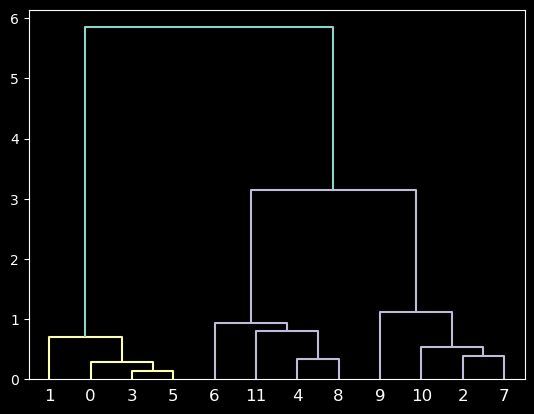

In [49]:
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline

link = linkage(X, method='ward')
#link = linkage(X, method='complete')

dendrogram(link);
plt.show()

### 3D dendrogram

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def get_df_hier( link, XX ):

    df = pd.DataFrame( {'x':XX[:,0],
                        'y':XX[:,1],
                        'd':np.zeros(XX.shape[0]),
                        'pts1':list(map(str,range(XX.shape[0]))),
                        'pts2':list(map(str,range(XX.shape[0]))),
                        'npts':np.ones(XX.shape[0])
                       } )

    for i in range(len(link)):

        c1, c2, d, _ = link[i]
        c1 = int(c1)
        c2 = int(c2)
        #print(f"Merge clusters {c1}, {c2} at distance {d}")

        pts1 = np.array(df.iloc[c1].pts1.split(',')).astype(int)
        pts2 = np.array(df.iloc[c2].pts1.split(',')).astype(int)
        pts3 = np.append( pts1, pts2 )

        mean = df[['x','y']].iloc[pts3].mean()

        df = pd.concat( [ df, pd.Series([mean[0],
                                         mean[1],
                                         d,
                                         ','.join(np.sort(pts3).astype(str)),
                                         ','.join(np.sort([c1,c2]).astype(str)),
                                         pts3.shape[0]],
                                        index=df.columns).to_frame().T ], ignore_index=True )
    # end
    
    return df
# end

def plot3d_hier(df, X):

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df.x[:X.shape[0]], df.y[:X.shape[0]], df.d[:X.shape[0]], s=200, c='b')
    ax.scatter(df.x[X.shape[0]:], df.y[X.shape[0]:], df.d[X.shape[0]:], s=200, c='r')

    #ax.w_xaxis.pane.fill = False
    #ax.w_yaxis.pane.fill = False
    #ax.w_zaxis.pane.fill = False
    ax.set_facecolor('black')

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    for i in range(X.shape[0],df.shape[0]):
        pts = np.array(df.iloc[i].pts2.split(',')).astype(int)

        x = [ df.x[i], df.x[pts[0]] ]
        y = [ df.y[i], df.y[pts[0]] ]
        z = [ df.d[i], df.d[pts[0]] ]

        ax.plot( x, y, z, c='k', linewidth=6 )

        x = [ df.x[i], df.x[pts[1]] ]
        y = [ df.y[i], df.y[pts[1]] ]
        z = [ df.d[i], df.d[pts[1]] ]

        ax.plot( x, y, z, c='k', linewidth=6 )
    # end
# end

In [9]:
%matplotlib qt

for i in range(len(link)):
    cluster1, cluster2, distance, num_points = link[i]
    #print(f"Merge clusters {int(cluster1)}, {int(cluster2)} at distance {distance} with {int(num_points)} points")
# end

df = get_df_hier( link, X )

plot3d_hier(df, X)

# Agglomerative Clustering with `sklearn`

`sklearn.cluster.AgglomerativeClustering` is a flexible tool for hierarchical clustering.  
It builds nested clusters by successively merging or splitting them.  
Key arguments include:

- `n_clusters`: The number of clusters to find. If known, set it directly.  
  If you don’t know it, you can set `distance_threshold` instead.
- `distance_threshold`: The linkage distance at which clusters will stop merging.  
  If set, `n_clusters` must be `None`. This lets you build a dendrogram and cut at any level.
- `linkage`: The linkage criterion — `'ward'` (minimize variance), `'complete'` (max distance), `'average'` (average distance), or `'single'` (nearest neighbors).
- `affinity` or `metric`: The distance metric for linkage — e.g., `'euclidean'`, `'manhattan'`.  
  (Note: `'ward'` only works with `'euclidean'`.)
- `compute_full_tree`: Controls whether to build the full tree. If using `distance_threshold`, this must be `True` (default).

**Typical usage:**
- If you know how many clusters you want: set `n_clusters` and leave `distance_threshold=None`.
- If you want to decide based on distance: set `distance_threshold` and `n_clusters=None` and visualize the merge distances.

This flexibility makes agglomerative clustering great for exploring hierarchical structures.


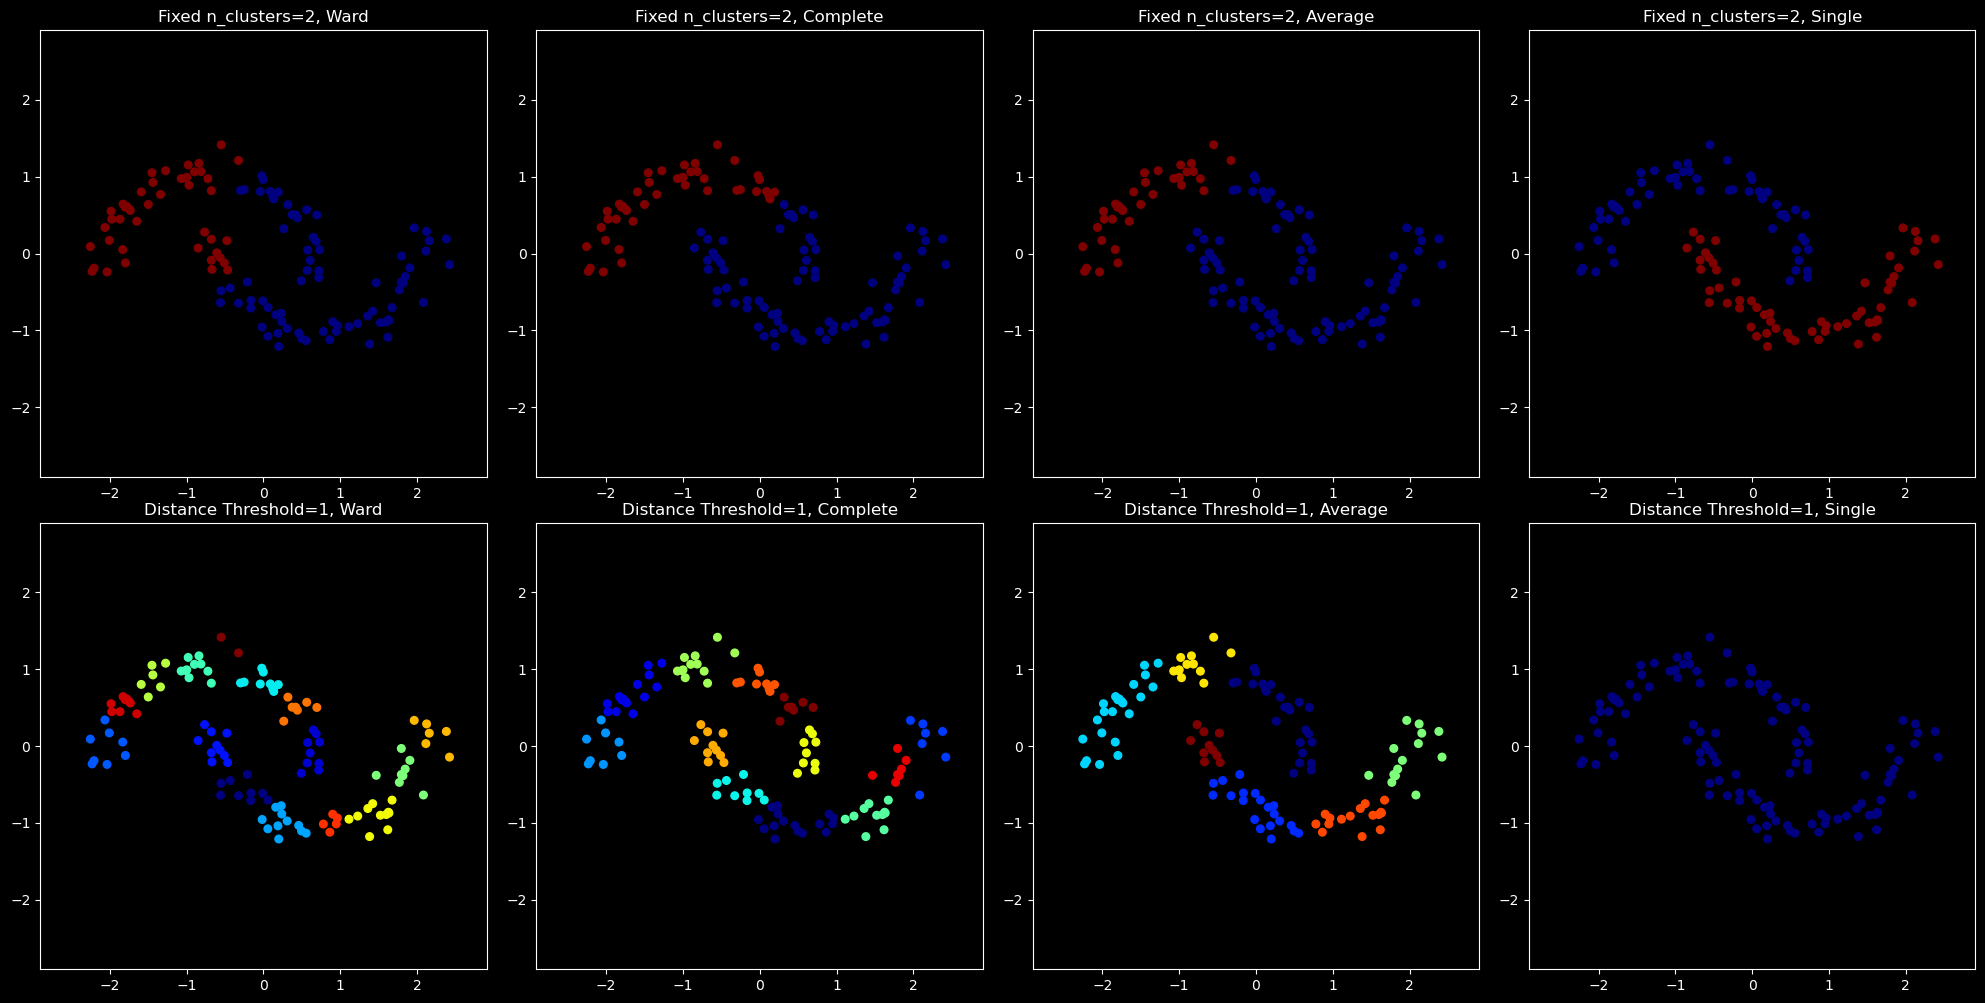

In [45]:
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

cmap = 'jet'

# Control variables
N_CLUSTERS = 2
DIST_THRESH = 1

# Fixed n_clusters models
model_fixed_ward = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='ward',
)
labels_fixed_ward = model_fixed_ward.fit_predict(X)

model_fixed_complete = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='complete',
)
labels_fixed_complete = model_fixed_complete.fit_predict(X)

model_fixed_average = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='average',
)
labels_fixed_average = model_fixed_average.fit_predict(X)

model_fixed_single = AgglomerativeClustering(
    n_clusters=N_CLUSTERS,
    linkage='single',
)
labels_fixed_single = model_fixed_single.fit_predict(X)

# Distance threshold models
model_thresh_ward = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=DIST_THRESH,
    linkage='ward',
)
labels_thresh_ward = model_thresh_ward.fit_predict(X)

model_thresh_complete = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=DIST_THRESH,
    linkage='complete',
)
labels_thresh_complete = model_thresh_complete.fit_predict(X)

model_thresh_average = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=DIST_THRESH,
    linkage='average',
)
labels_thresh_average = model_thresh_average.fit_predict(X)

model_thresh_single = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=DIST_THRESH,
    linkage='single',
)
labels_thresh_single = model_thresh_single.fit_predict(X)

# Plot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Top row: fixed clusters
axes[0, 0].scatter(X[:, 0], X[:, 1], c=labels_fixed_ward, cmap=cmap, s=30)
axes[0, 0].set_title(f"Fixed n_clusters={N_CLUSTERS}, Ward")
axes[0, 1].scatter(X[:, 0], X[:, 1], c=labels_fixed_complete, cmap=cmap, s=30)
axes[0, 1].set_title(f"Fixed n_clusters={N_CLUSTERS}, Complete")
axes[0, 2].scatter(X[:, 0], X[:, 1], c=labels_fixed_average, cmap=cmap, s=30)
axes[0, 2].set_title(f"Fixed n_clusters={N_CLUSTERS}, Average")
axes[0, 3].scatter(X[:, 0], X[:, 1], c=labels_fixed_single, cmap=cmap, s=30)
axes[0, 3].set_title(f"Fixed n_clusters={N_CLUSTERS}, Single")

# Bottom row: distance threshold
axes[1, 0].scatter(X[:, 0], X[:, 1], c=labels_thresh_ward, cmap=cmap, s=30)
axes[1, 0].set_title(f"Distance Threshold={DIST_THRESH}, Ward")
axes[1, 1].scatter(X[:, 0], X[:, 1], c=labels_thresh_complete, cmap=cmap, s=30)
axes[1, 1].set_title(f"Distance Threshold={DIST_THRESH}, Complete")
axes[1, 2].scatter(X[:, 0], X[:, 1], c=labels_thresh_average, cmap=cmap, s=30)
axes[1, 2].set_title(f"Distance Threshold={DIST_THRESH}, Average")
axes[1, 3].scatter(X[:, 0], X[:, 1], c=labels_thresh_single, cmap=cmap, s=30)
axes[1, 3].set_title(f"Distance Threshold={DIST_THRESH}, Single")

# Set limits and aspect ratio for all plots
for ax in axes.flat:
    ax.set_xlim(-MAX, MAX)
    ax.set_ylim(-MAX, MAX)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

### No predict method (can't aply model to new data)

In [25]:
model_fixed_ward.predict(X)

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

## Comparison w/ K-means and GMM

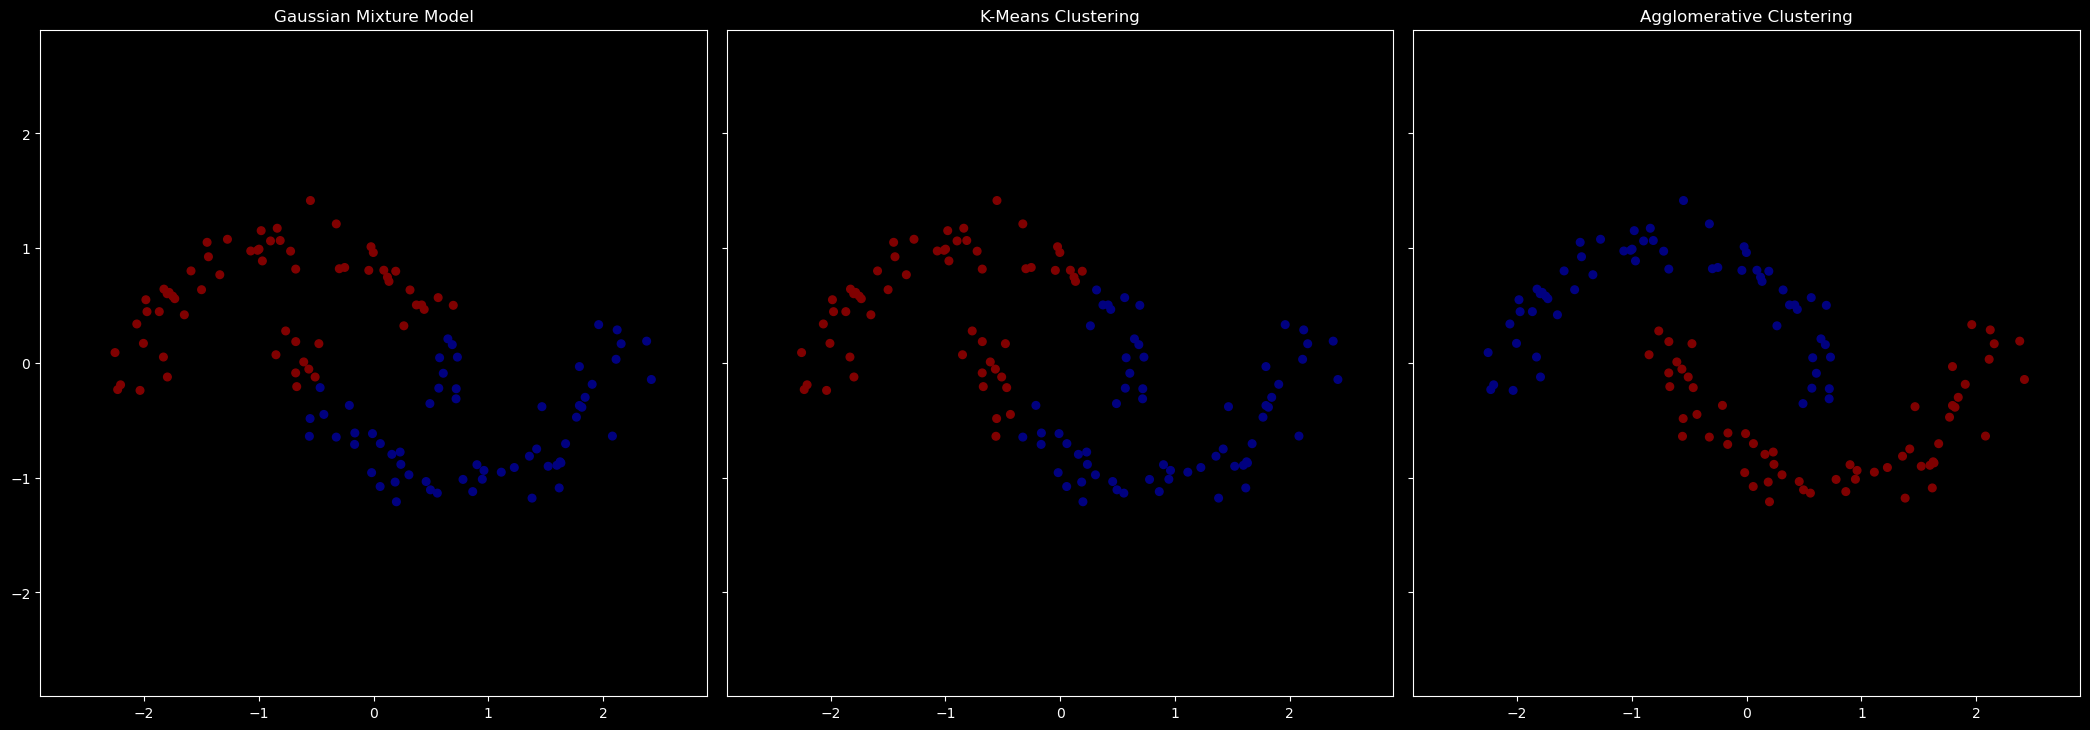

In [47]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Control: number of clusters/components
k = 2

# ================================
# Fit Gaussian Mixture Model (GMM)
# ================================
gmm_model = GaussianMixture(
    n_components=k,
    random_state=0,
)
gmm_model.fit(X)
labels_gmm = gmm_model.predict(X)

# ================================
# Fit K-Means Model
# ================================
kmeans_model = KMeans(
    n_clusters=k,
    n_init="auto",
    random_state=0,
)
kmeans_model.fit(X)
labels_kmeans = kmeans_model.predict(X)

# ================================
# Fit Agglomerative Clustering
# ================================
agglo_model = AgglomerativeClustering(
    n_clusters=k,
    linkage='single',
)
labels_agglo = agglo_model.fit_predict(X)

extent = [-MAX, MAX, -MAX, MAX]

# ================================
# Side-by-Side Plots (GMM, KMeans, Agglo)
# ================================
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)

# -- GMM Plot --
axes[0].scatter(X[:, 0], X[:, 1], c=labels_gmm, s=30, cmap=cmap)
axes[0].set_title("Gaussian Mixture Model")
axes[0].set_xlim(-MAX, MAX)
axes[0].set_ylim(-MAX, MAX)
axes[0].set_aspect('equal')

# -- K-Means Plot --
axes[1].scatter(X[:, 0], X[:, 1], c=labels_kmeans, s=30, cmap=cmap)
axes[1].set_title("K-Means Clustering")
axes[1].set_xlim(-MAX, MAX)
axes[1].set_ylim(-MAX, MAX)
axes[1].set_aspect('equal')

# -- Agglomerative Clustering Plot --
axes[2].scatter(X[:, 0], X[:, 1], c=labels_agglo, s=30, cmap=cmap)
axes[2].set_title("Agglomerative Clustering")
axes[2].set_xlim(-MAX, MAX)
axes[2].set_ylim(-MAX, MAX)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()